# `IMPORTS`

In [49]:
import math
import inflection

import pandas               as pd
import numpy                as np
import datetime             as dt
import missingno            as msno
import seaborn              as sns
import matplotlib.pyplot    as plt
import ptitprince          as pt
import plotly.graph_objs    as go

from IPython.display        import Image
from scipy                  import stats
from matplotlib.gridspec    import GridSpec

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [105]:
def jupyter_settings():
    #%matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

## Loading Data

In [51]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# `DESCRIÇÃO DOS DADOS`

In [52]:
df1 = df_raw.copy()

## Data Fields

| **Coluna** | **Descrição** |
|---|---|
| **Id** | Um ID que representa uma duplicata (Loja, Data) dentro do conjunto de teste |
| **Loja (Store)** | Um ID exclusivo para cada loja |
| **Vendas (Sales)** | O volume de negócios para um determinado dia (é o que você está prevendo) |
| **Clientes (Customers)** | O número de clientes em um determinado dia |
| **Aberto (Open)** | Um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto |
| **Feriado Estadual (StateHoliday)** | Indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais. Observe que todas as escolas estão fechadas nos feriados e fins de semana. a = feriado, b = feriado da páscoa, c = natal, 0 = nenhum |
| **Feriado Escolar (SchoolHoliday)** | Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas |
| **Sortimento (Assortment)** | Descreve um nível de sortimento: a = básico, b = extra, c = estendido |
| **Distância da Concorrência (CompetitionDistance)** | Distância em metros até a loja concorrente mais próxima |
| **Abertura da Concorrência (CompetitionOpenSince[Month/Year])** | Fornece o ano e o mês aproximados em que o concorrente mais próximo foi aberto |
| **Promoção (Promo)** | Indica se uma loja está executando uma promoção naquele dia |
| **Promoção 2 (Promo2)** | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando |
| **Início da Promoção 2 (Promo2Since[Year/Week])** | Descreve o ano e a semana do calendário em que a loja começou a participar do Promo2 |
| **Intervalo da Promoção (PromoInterval)** | Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja |


## Rename Columns

In [53]:
# Lista das colunas originais
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Função para transformar os nomes das colunas em snake_case
snakecase = lambda x: inflection.underscore(x)

# Aplica a função em todas as palavras de cols_old, armazenando os resultados em cols_new
cols_new = [snakecase(col) for col in cols_old]

# Renomeia as colunas do DataFrame df1 com os novos nomes em snake_case
df1.columns = cols_new

## Data Dimensions

In [54]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## Data Types

In [55]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [56]:
# Converter a coluna 'date' para datetime
df1['date'] = pd.to_datetime(df1['date'])

## Check NA

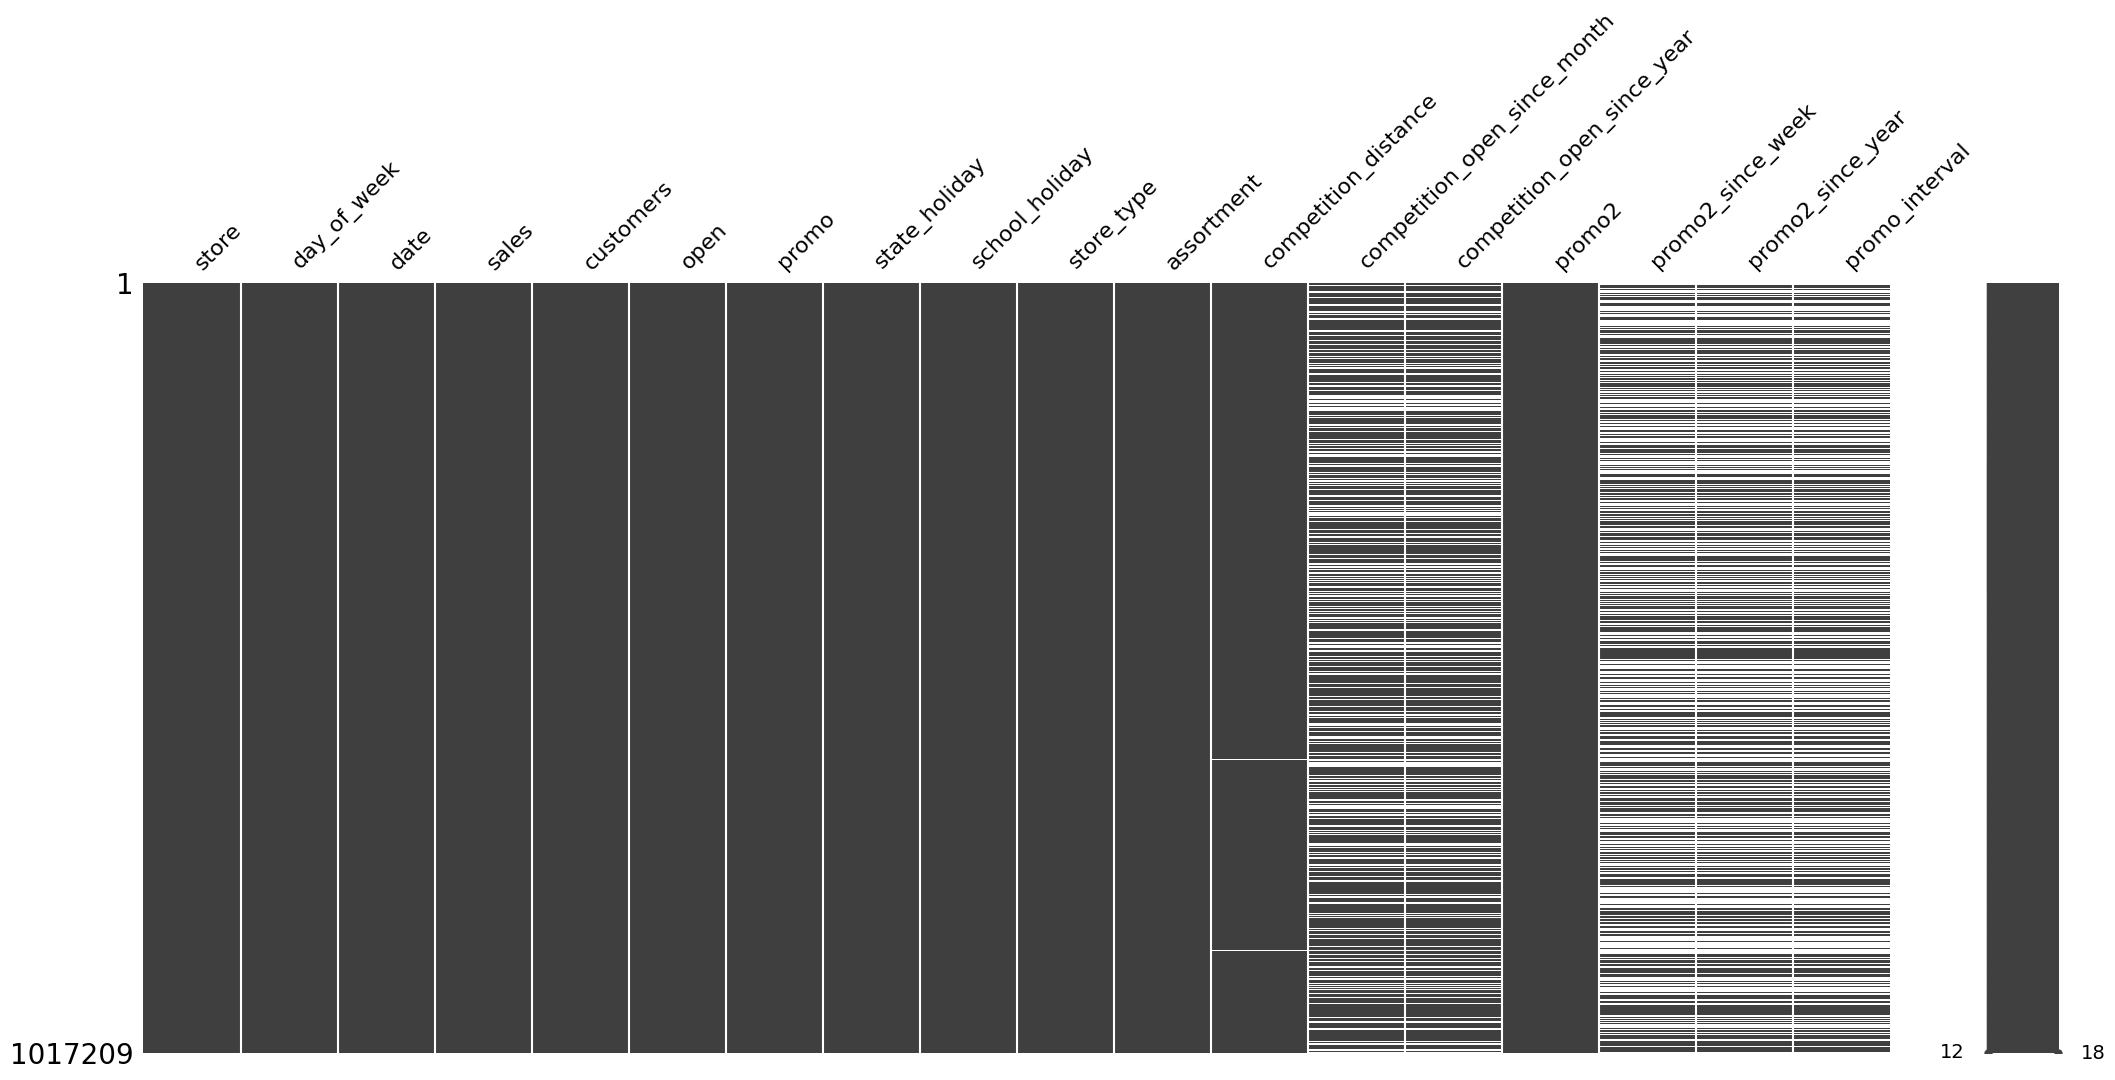

In [57]:
# Mostrar uma matriz de valores ausentes (NaN) no DataFrame df1 usando a função msno.matrix
msno.matrix(df1);

In [58]:
# Contar o número de valores ausentes (NaN) em cada coluna do DataFrame df1
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Analyze all NA cases

**Casos de NA para serem tratados:**

| **Colunas**                      | **NA**    |
|----------------------------------|-----------|
| competition_distance             | 2642      |
| competition_open_since_month     | 323348    |
| competition_open_since_year      | 323348    |
| promo2_since_week                | 508031    |
| promo2_since_year                | 508031    |
| promo_interval                   | 508031    |


#### Caso 1 - Competition_distance: indica a distancia em metros do competidor mais próximo

In [59]:
""" 
Assumindo que no caso de valores ausente não há competidores próximos.
Vou vou atribuir pros NAs um valor bem maior que o maior valor de distância existente.
"""

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#### Caso 2 - competition_open_since_month: indica o mês aproximado da abertura do competidor mais próximo

In [60]:
"""
Se esta coluna está vazia, é porque pode não haver competidor próximo ou pode ser devido à falta de informação sobre a data de abertura.
Vou assumir que a data de venda (date) é a mesma que a data de abertura do competidor.
"""

df1['competition_open_since_month'] = df1.apply(lambda x: x.date.month if math.isnan(x.competition_open_since_month) else x.competition_open_since_month, axis=1)


#### Caso 3 - competition_open_since_year: indica ano aproximado da abertura do competidor mais próximo

In [61]:
# Vou assumir para years a mesama solução realizada em month
df1['competition_open_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year, axis=1)

#### Caso 4 - promo2_since_week: indica a semana do calendário em que a loja começou a participar do Promo2

In [62]:
"""
Descreve a semana do calendário em que a loja começou a participar do Promo2
Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

vou manter a mesma estratégia, utilizando a data de venda como referência para definir esses valores.
"""

df1['promo2_since_week'] = df1.apply(lambda x: x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis=1)

#### Caso 5 - promo2_since_year: indica o ano do calendário em que a loja começou a participar do Promo2

In [63]:
"""
Descreve o ano do calendário em que a loja começou a participar do Promo2
Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

vou manter a mesma estratégia, utilizando a data de venda como referência para definir esses valores.
"""

df1['promo2_since_year'] = df1.apply(lambda x: x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis=1)

#### Caso 6 - promo_interval: indica o intervalo de tempo entre as promoções

In [64]:
"""
Para resolver a questão dos valores NA neste caso, 
optei em preenchê-los com zeros como uma medida para garantir a integridade dos dados 
e simplificar as etapas de análise subsequentes.
"""

# month_map é um dicionário que mapeia números de mês para abreviações de meses.
month_map = {1: 'jan', 
             2: 'Feb', 
             3: 'Mar', 
             4: 'Apr', 
             5: 'May',
             6: 'Jun', 
             7: 'Jul', 
             8: 'Aug', 
             9: 'Sept', 
             10:'Oct', 
             11:'Nov', 
             12:'Dec'}

# Preenche os valores ausentes na coluna 'promo_interval' com 0 e modifica o DataFrame inplace.
df1['promo_interval'].fillna(0, inplace=True);

# Cria uma nova coluna 'month_map' que mapeia os meses baseado na coluna 'date'.
df1['month_map'] = df1['date'].dt.month.map(month_map);

# Cria uma nova coluna 'is_promo' para indicar se uma promoção está ocorrendo no mês correspondente.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1);


### Result

In [65]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change Types

In [66]:
# Após as alterações realizadas nas colunas, é essencial verificar se o formato dos dados permaneceu o mesmo.
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [67]:
# converter de float pra int64
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [68]:
# Conferindo
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Descriptive Statistical

In [69]:
#Separação de Variáveis Numéricas e Categóricas para Aplicação da analise descritiva:
num_attributes = df1.select_dtypes ( include=['int64','float64'] )
cat_attributes = df1.select_dtypes ( exclude=['int64','float64','datetime64[ns]'] )

### Numerical Attribures

In [70]:
#Central Tendency - mean - median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - STD, min, max, range, sken, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


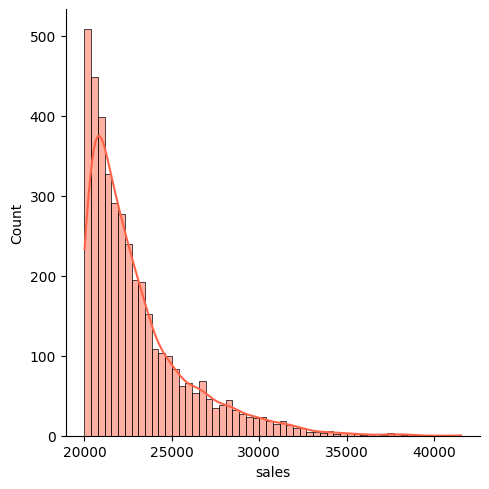

In [71]:
# Criar uma máscara booleana para identificar valores de 'sales' maiores que 20000
aux = df1['sales'] > 20000

# Aplicar a máscara para selecionar os dados filtrados da coluna 'sales'
dados_filt = df1.loc[aux, 'sales']

# Plotar o histograma com KDE para os dados filtrados
sns.displot(dados_filt, kde=True, color='#FF6347');

### Categorical Attibures

In [72]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

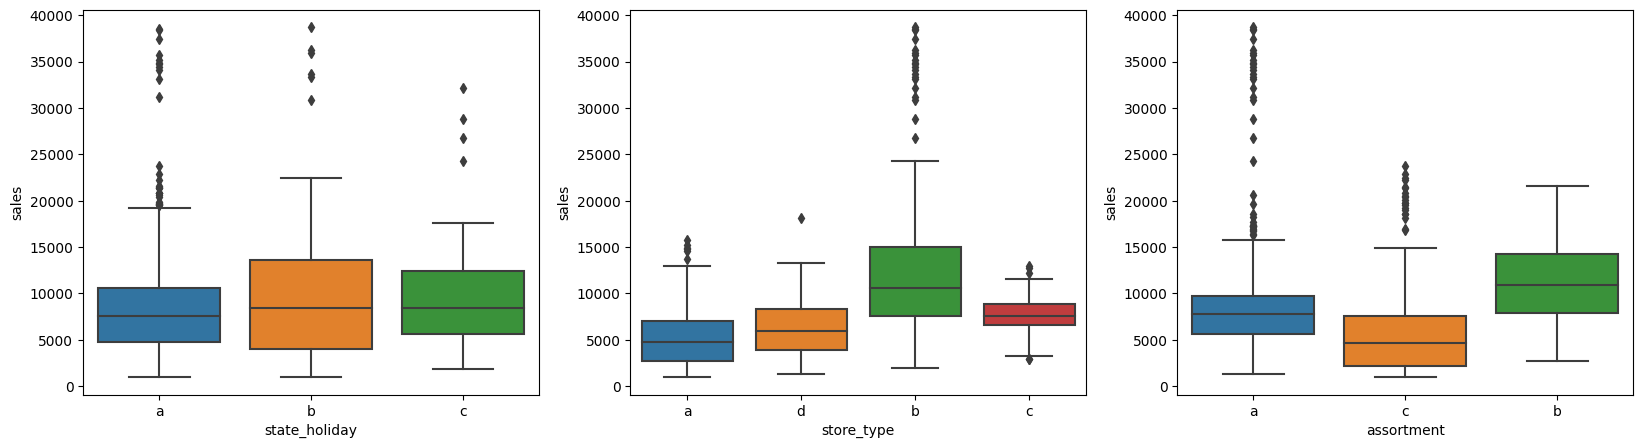

In [73]:
# Paleta de cores personalizada
# cores = ["#FF6347", "#4682B4", "#32CD32", "#FFD700"]

#Atualizei o cálculo para desconsiderar os dias sem vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] 

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

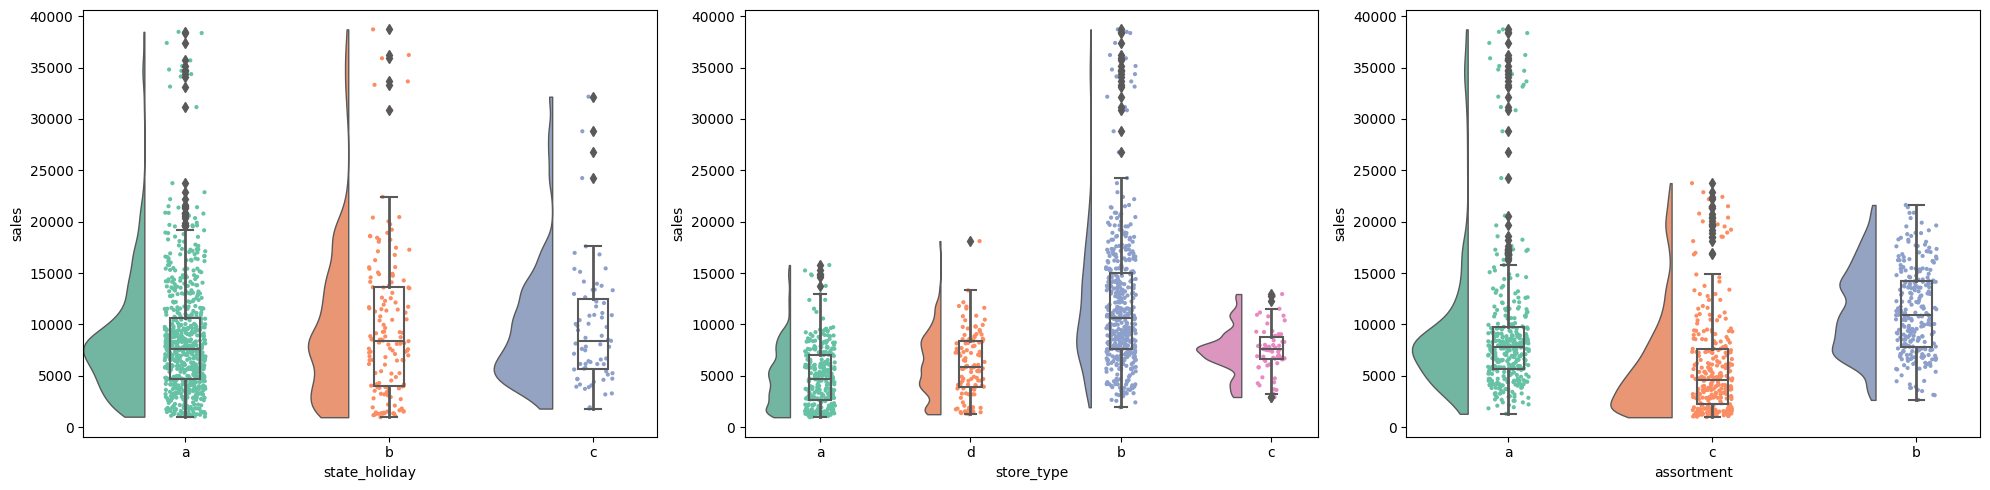

In [74]:
# Configurações para o gráfico de nuvem de chuva (RainCloud plot)
pal = 'Set2'  # Paleta de cores
sigma = .2  # Largura do KDE
ort = 'v'  # Orientação do gráfico (vertical)

# a figura e os subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# gráfico de nuvem de chuva (RainCloud plot) para cada subplot
pt.RainCloud(x='state_holiday', y='sales', palette=pal, bw=sigma, width_viol=.6, ax=axes[0], orient=ort, data=aux1)
pt.RainCloud(x='store_type', y='sales', palette=pal, bw=sigma, width_viol=.6, ax=axes[1], orient=ort, data=aux1)
pt.RainCloud(x='assortment', y='sales', palette=pal, bw=sigma, width_viol=.6, ax=axes[2], orient=ort, data=aux1)

plt.tight_layout()  # Ajusta automaticamente o layout para evitar sobreposição

#### `Análise do violinplot 1: quantidade de vendas por tipo de feriado:`

Legenda de :
- a = feriado público
- b = feriado de Páscoa
- c = Natal

A mediana de vendas nos feriados de Páscoa (b) e Natal (c) é mais alta do que nos feriados públicos (a).

A mediana de vendas nos feriados de Páscoa (b) e Natal (c) é semelhante, porém a dispersão é maior durante a Páscoa.

#### `Análise do violinplot 2: quantidade de vendas por tipo de loja:`

Legenda de StoreType:
- a
- d
- b
- c

A loja do tipo b vende aproximadamente o dobro da mediana em comparação com as outras, especialmente a do tipo a.

A concentração de vendas ao redor da mediana é maior para a loja do tipo c.

#### `Análise do violinplot 3: quantidade de vendas por mix de produtos:`

Legenda de Assortment:
- a = básico
- b = extra
- c = estendido

O mix de produtos extra (b) tem significativamente mais vendas do que os outros. Além disso, a variabilidade nas vendas é maior para esse mix.

O mix básico (a) possui muitos outliers, mas a distribuição das vendas fora desses outliers é bastante uniforme.

In [75]:
#contar a quantidade de valores únicos em cada coluna que contém atributos categóricos
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

# `FEATURE ENGINEERING`

In [76]:
df2 = df1.copy()

## Mindmap de Hipóteses

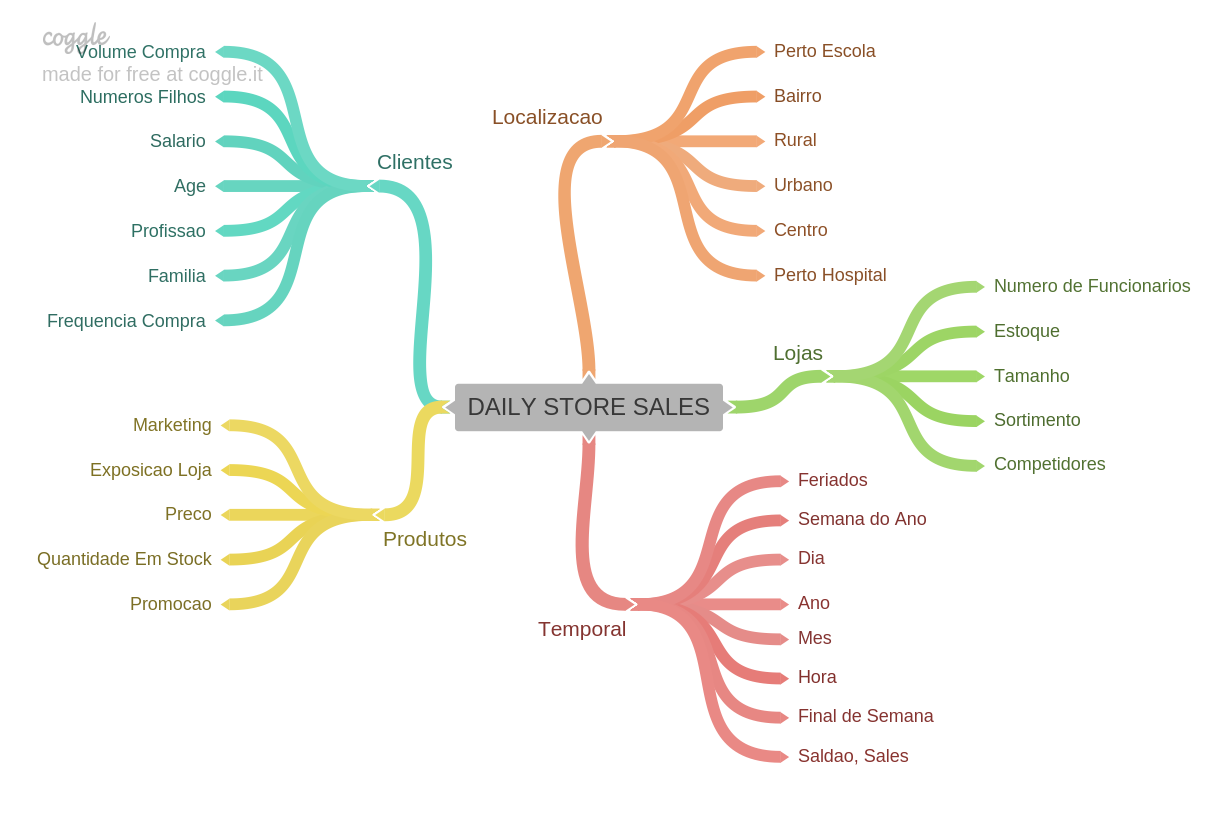

In [77]:
Image ('../img/mindmap.png')

### Criação das Hipóteses

#### As Hipóteses Loja
1 Lojas com numero maior de funcionarios deveriam vender mais. (Não temos o numero de funcionario neste momento)

2 Lojas com maior capacidade de estoque deveriam vender mais. (Não temos a informação do estoque)

3 Lojas com maior porte deveriam vender mais. (Não temos o tamanho da loja)

4 Lojas com maior sortimento deveriam vender mais.

5 Lojas com competidores mais proximos deveriam vender menos.

6 Lojas com competidores a mais tempo deveriam vender mais.


#### As Hipoteses Produto
1 Lojas que investem mais em Marketing deveriam vender mais. (Não temos essa informação)

2 Lojas com maior exposição de produto deveria vender mais. (Não temos a quantidade de produtos)

3 Lojas com produtos e preço menor deveria vender mais. (Não temos os preços dos produtos)

4 Lojas com promoçoes mais agressivas (desconto maiores), deveriam vender mais.

5 Lojas com promoções ativas por mais tempo deveriam vender mais.

6 Lojas com mais dias de promoção deveriam vender mais.

7 Lojas com mais promoções consecutivas deveriam vender mais.


#### Hipotese Tempo
1 Lojas aberta durante o feriado de Natal deveriam vender mais.

2 Lojas deveriam vender mais .

3 Lojas deveriam vender mais no segundo semetre do ano.

4 Lojas deveriam vender mais depois do dia 10 de cada mes.

5 Lojas deveriam vender menos aos finanis de semana.

6 Lojas deveria vender menos durante os feriados escolares.


#### Lista final de Hipóteses


1 Lojas com maior sortimento deveriam vender mais.

2 Lojas com competidores mais proximos deveriam vender menos.

3 Lojas com competidores a mais tempo deveriam vender mais.

4 Lojas com promoções ativas por mais tempo deveriam vender mais.

5 Lojas com mais dias de promoção deveriam vender mais.

6 Lojas com mais promoções consecutivas deveriam vender mais.

7 Lojas aberta durante o feriado de Natal deveriam vender mais.

8 Lojas deveriam vender mais .

9 Lojas deveriam vender mais no segundo semetre do ano.

10 Lojas deveriam vender mais depois do dia 10 de cada mes.

11 Lojas deveriam vender menos aos finanis de semana.

12 Lojas deveria vender menos durante os feriados escolares.

## Feature Engineering

In [78]:
# year 
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
"""
criando a competition_since, que é a junção competition_open_since_year e competition_time_month.
day=1 visto que só tenho o ano e o mẽs, vou colocar todo o dia primeiro de cada mês e vou considerar o mês como um todo.
"""

df2['competition_since'] = df2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], 
                                                           month=x['competition_open_since_month'], day=1), axis=1)

# tempo desde que a competição começou em meses, convertidos em numeros inteiros
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

# promo since
# ano - semana do ano
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# subscrevendo a promo_since e convertendo para datetime
df2['promo_since'] = df2['promo_since'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )
# o tempo em que a promoção está ativa em semanas. 
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
# Transformando os níveis de sortimento ('a', 'b', 'c') em categorias mais descritivas ('basic', 'extra', 'extended')
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# # Transformando os tipos de feriados ('a', 'b', 'c') em categorias mais descritivas ('public_holiday', 'easter_holiday', 'christmas')
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [79]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# `FILTRAGEM DE VARIÁVEIS`

In [80]:
df3 = df2.copy()

## Filtragem das Linhas

In [81]:
# Não considerar as lojas que estão fechadas.
# Não considerar sales = 0
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]

## Seleção das Colunas

In [82]:
"""
# Drop de colunas:

- restrição de negocio, não tem como mensurar a quantidade de customers no nomemnto, apenas em um projeto a parte
- a coluna 'open' sem variabilidade, contendo apenas '1'
- a coluna 'promo_interval' derivou a 'is_promo'
- a coluna 'month_map' foi utilizada como auxiliar
"""

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## Data Fields 2

| **Coluna**                       | **Descrição**                                                                                                                   |
|:-------------------------------- |:------------------------------------------------------------------------------------------------------------------------------- |
| **store**                        | Um ID exclusivo para cada loja                                                                                                  |
| **day_of_week**                  | Indica o dia da semana                                                                                                          |
| **date**                         | Data do registro                                                                                                                |
| **sales**                        | Faturamento da loja naquele dia                                                                                                 |
| **promo**                        | Indica se uma loja está executando uma promoção naquele dia: 0 = a loja não está participando, 1 = a loja está participando.                                                                    |
| **state_holiday**                | Indica um feriado estadual. ('public_holiday', 'easter_holiday', 'christmas')                                                   |
| **school_holiday**               | Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas                                                        |
| **store_type**                   | Indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)                                                                   |
| **assortment**                   | Descreve um nível de sortimento: básico, extra, estendido                                                                       |
| **competition_distance**         | Distância em metros até a loja concorrente mais próxima                                                                         |
| **competition_open_since_month** | Fornece o mês aproximado em que o concorrente mais próximo foi aberto                                                           |
| **competition_open_since_year**  | Fornece o ano aproximado em que o concorrente mais próximo foi aberto                                                           |
| **promo2**                       | Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando |
| **promo2_since_week**            | Descreve a semana do calendário em que a loja começou a participar do Promo2                                                    |
| **promo2_since_year**            | Descreve o ano do calendário em que a loja começou a participar do Promo2                                                       |
| **is_promo**                     | Indica se uma promoção está ocorrendo no mês correspondente. 0 = Não, 1 = Sim.                                                  |
| **year**                         | Ano                                                                                                                             |
| **month**                        | Mês                                                                                                                             |
| **day**                          | Dia                                                                                                                             |
| **week_of_year**                 | Semana do ano                                                                                                                   |
| **year_week**                    | Ano e Semana                                                                                                                    |
| **competition_since**            | Tempo desde que a competição começou. Junção competition_open_since_year e competition_open_since_month                         |
| **competition_time_month**       | Tempo desde que a competição começou em meses, convertidos em números inteiros                                                  |
| **promo_since**                  | Data que iniciou a promoção.                                                                                                    |
| **promo_time_week**              | O tempo em que a promoção está ativa em semanas                                                                                 |


In [83]:
# Dicionário 
info = {
    "store": "Um ID exclusivo para cada loja",
    "day_of_week": "Indica o dia da semana",
    "date": "Data do registro",
    "sales": "Faturamento da loja naquele dia",
    "promo": "promo Indica se uma loja está executando uma promoção naquele dia: 0 = a loja não está participando, 1 = a loja está participando.",
    "state_holiday":  "Indica um feriado estadual. ('public_holiday', 'easter_holiday', 'christmas')",
    "school_holiday": "Indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas",
    "store_type": "Indica qual dos 4 modelos distintos é esta loja: (a, b, c, d)",
    "assortment": "Descreve um nível de sortimento: básico, extra, estendido",
    "competition_distance": "Distância em metros até a loja concorrente mais próxima",
    "competition_open_since_month": "Fornece o mês aproximado em que o concorrente mais próximo foi aberto",
    "competition_open_since_year": "Fornece o ano aproximado em que o concorrente mais próximo foi aberto",
    "promo2": "Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando",
    "promo2_since_week": "Descreve a semana do calendário em que a loja começou a participar do Promo2",
    "promo2_since_year": "Descreve o ano do calendário em que a loja começou a participar do Promo2",
    "is_promo": "Indica se uma promoção está ocorrendo no mês correspondente. 0 = Não, 1 = Sim.",
    "year": "Ano",
    "month": "Mês",
    "day": "Dia",
    "week_of_year": "Semana do ano",
    "year_week": "Ano e Semana",
    "competition_since": "Tempo desde que a competição começou. Junção competition_open_since_year e competition_open_since_month",
    "competition_time_month": "Tempo desde que a competição começou em meses, convertidos em números inteiros",
    "promo_since": "Data que iniciou a promoção.",
    "promo_time_week": "O tempo em que a promoção está ativa em semanas"
}


# `EDA`

In [84]:
df4 = df3.copy()

## Analise Univariada 

### Variável Resposta

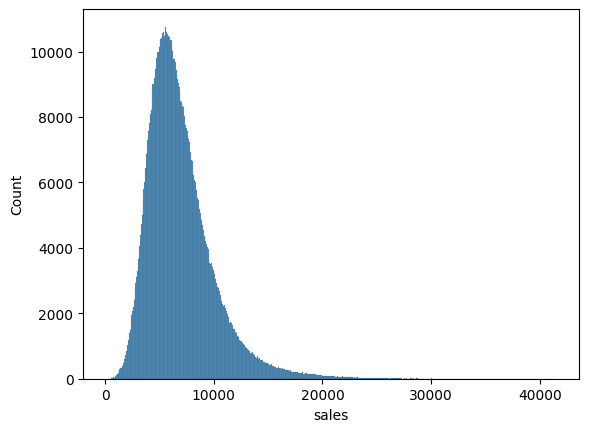

In [85]:
sns.histplot(df4['sales']);

In [86]:
m.iloc[2:3], stats.mode(df4['sales'])

(  attributes  min      max    range         mean  median          std  \
 2      sales  0.0  41551.0  41551.0  5773.818972  5744.0  3849.924283   
 
       skew  kurtosis  
 2  0.64146  1.778375  ,
 ModeResult(mode=5674, count=215))

### Variáveis Numéricas

In [87]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


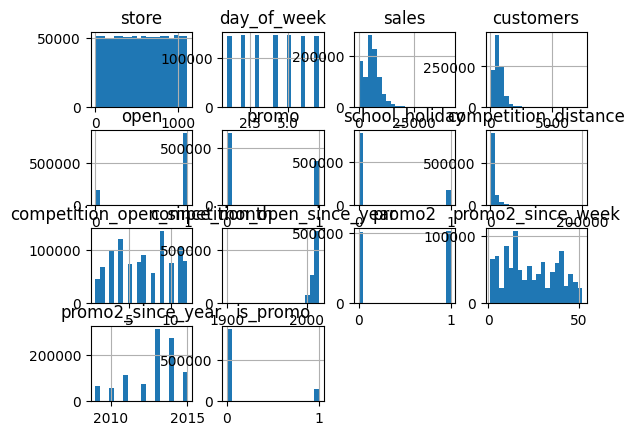

In [88]:
num_attributes.hist(bins=20);

### Variáveis Categoricas 

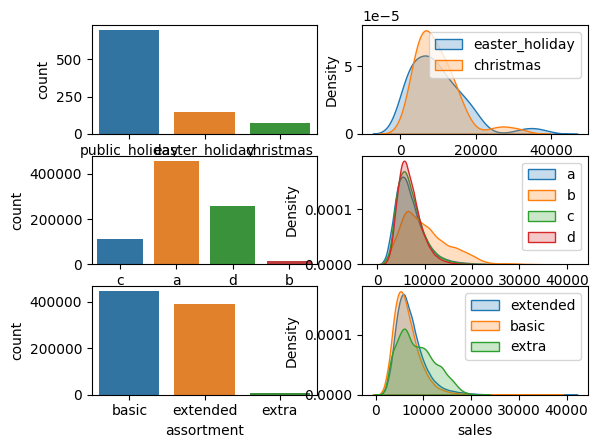

In [89]:
# state_holiday
# Primeiro subgráfico: Contagem de feriados estaduais
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day'] # Filtra os dados para excluir 'regular_day'
sns.countplot(a['state_holiday']) # Cria um gráfico de barras para os feriados estaduais


# Segundo subgráfico: Distribuição das vendas em diferentes feriados
plt.subplot(3, 2, 2)
# Plota a distribuição das vendas para feriados públicos
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True) # Plota a distribuição das vendas para feriados de Páscoa
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],      label='christmas',      shade=True) # Plota a distribuição das vendas para o Natal
plt.legend()

# store_type
# Terceiro subgráfico: Contagem de tipos de lojas
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])
  

# Quarto subgráfico: Distribuição das vendas por tipo de loja
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
# Quinto subgráfico: Contagem de sortimentos
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

# Sexto subgráfico: Distribuição das vendas por tipo de sortimento
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True) # distribuição das vendas para sortimento estendido
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],    label='basic',    shade=True) # distribuição das vendas para sortimento básico
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],    label='extra',    shade=True) # distribuição das vendas para sortimento extra
plt.legend()

## Análise Bivariada

### `H1`.Lojas com maior sortimento deveriam vender mais.

##### **`FALSA`** Lojas com MAIOR SORTIMENTO vendem MENOS.
- OBS.: Assumindo que o sortimento extra seja o maior dentre os sortimentos.

In [90]:
info['assortment']

'Descreve um nível de sortimento: básico, extra, estendido'

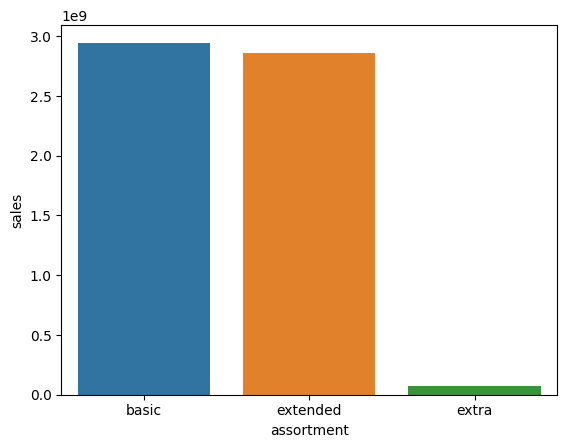

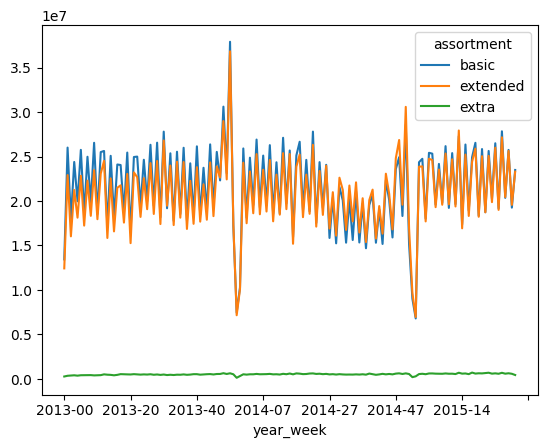

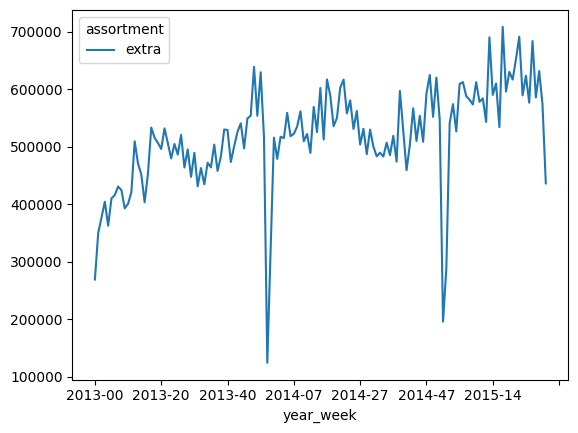

In [91]:
# Agrupar os dados de vendas pelo tipo de sortimento, somando as vendas para cada tipo
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Agrupar os dados pelas semanas do ano e tipo de sortimento, somando as vendas para cada combinação
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# Plotar um gráfico de linha mostrando as vendas semanais apenas para o sortimento 'extra'
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### `H2`.Lojas com competidores mais proximos deveriam vender menos.

##### **`FALSA`** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

In [92]:
info['competition_distance']

'Distância em metros até a loja concorrente mais próxima'

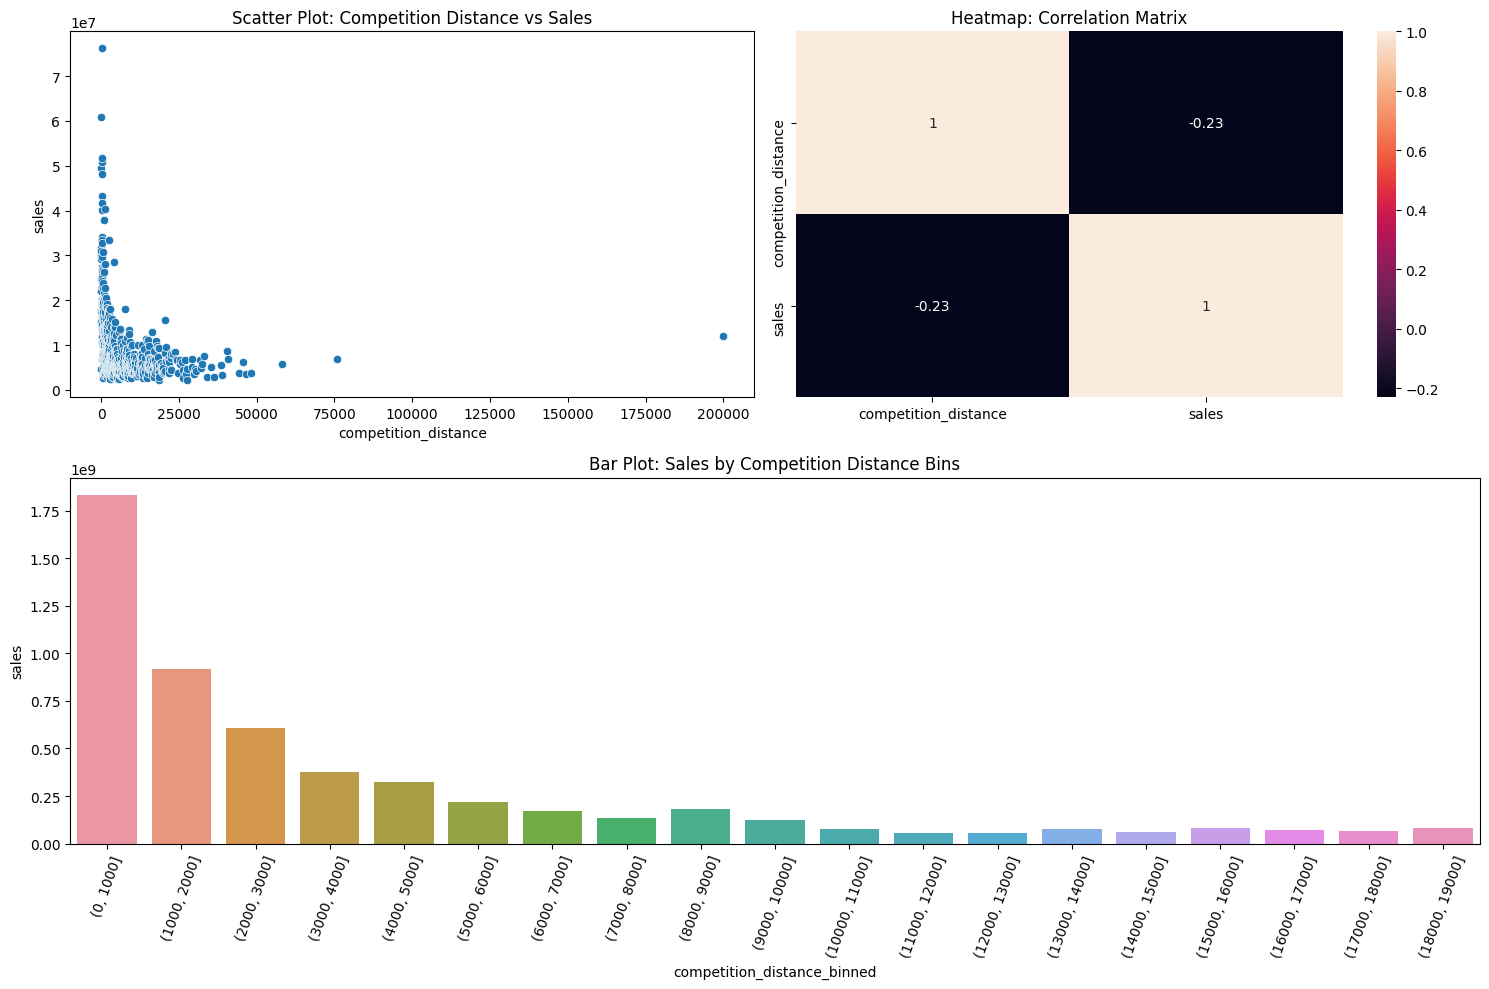

In [95]:
# Agrupar os dados por 'competition_distance' e somar as vendas ('sales') para cada distância de competição
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15, 10))

# Plotar o gráfico de dispersão entre 'competition_distance' e 'sales'
plt.subplot(221)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.title('Scatter Plot: Competition Distance vs Sales')

plt.subplot(212)
# Criar intervalos (bins) de 1000 em 1000 para 'competition_distance'
bins = list(np.arange(0, 20000, 1000))
# Adicionar uma nova coluna ao dataframe 'aux1' com os valores binned de 'competition_distance'
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
# Agrupar os dados por intervalos de 'competition_distance' e somar as vendas ('sales') para cada intervalo
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
# Plotar um gráfico de barras para as vendas ('sales') por intervalo de distância de competição
sns.barplot(x= 'competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=70);
plt.title('Bar Plot: Sales by Competition Distance Bins')


plt.subplot(222)
# Plotar a matriz de correlação entre 'competition_distance' e 'sales'
x = sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title('Heatmap: Correlation Matrix') 

plt.tight_layout()

### `H3`.Lojas com competidores a mais tempo deveriam vender mais.

##### **`FALSA`** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

In [96]:
info['competition_time_month']

'Tempo desde que a competição começou em meses, convertidos em números inteiros'

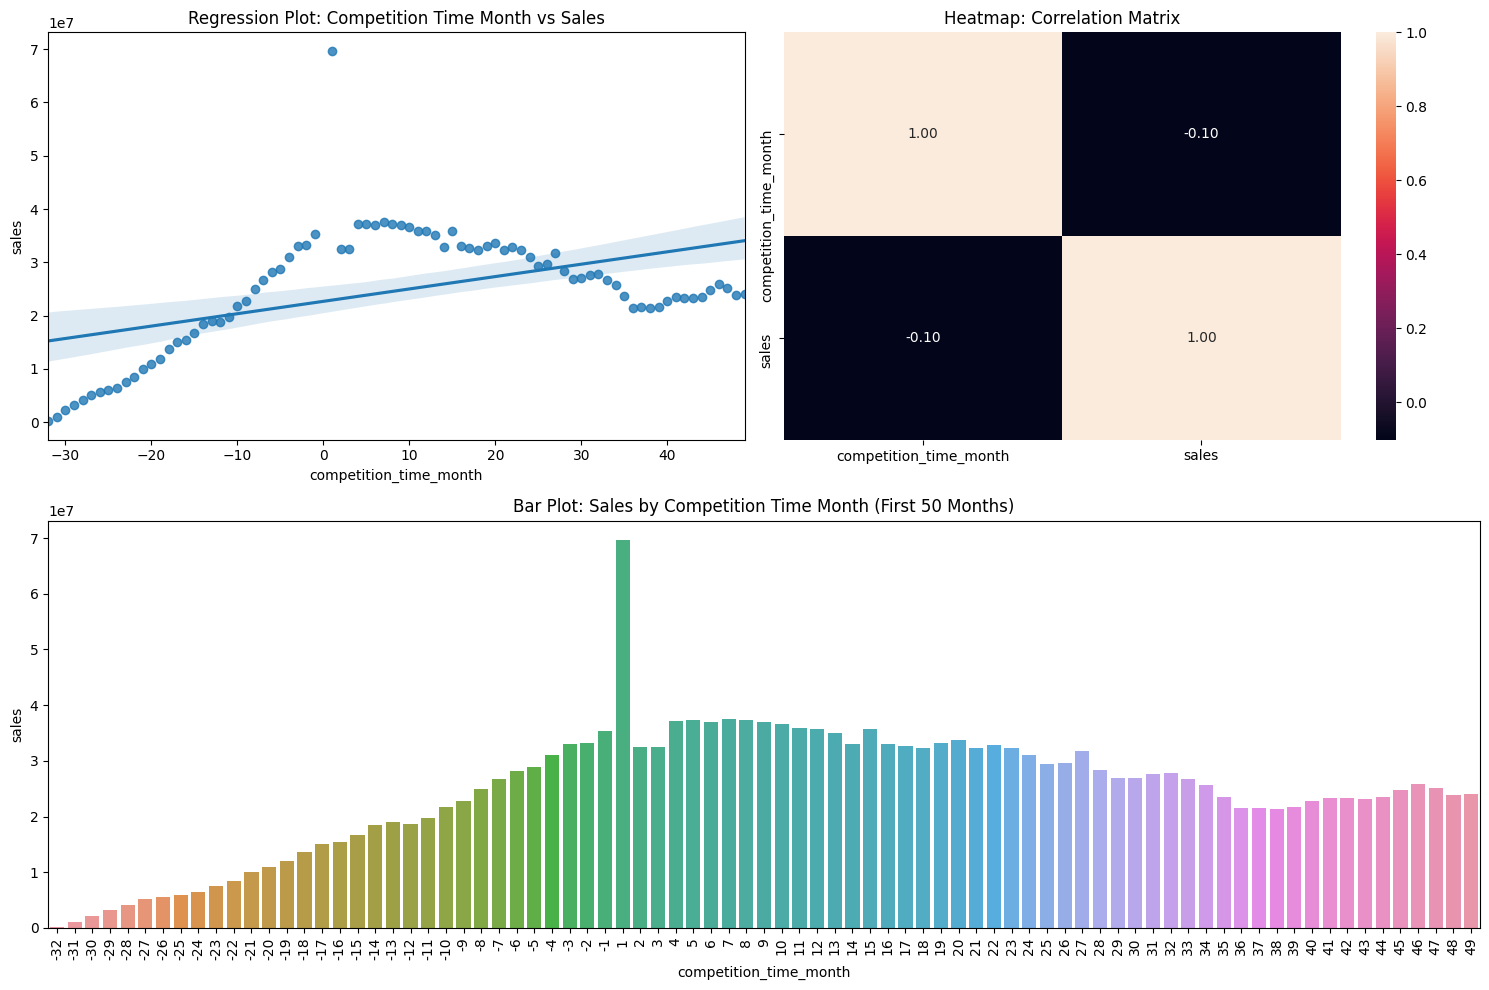

In [97]:
# Agrupar os dados por 'competition_time_month' e somar as vendas ('sales') para cada mês de competição
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.figure(figsize=(15, 10))

plt.subplot(212)
# filtrar apenas os 50 primeiros meses de competição e tempo de competição diferente de zero
aux2 = aux1[(aux1['competition_time_month'] < 50)  & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90)
plt.title('Bar Plot: Sales by Competition Time Month (First 50 Months)');

plt.subplot(221)
# Plotar um gráfico de regressão para mostrar a relação entre 'competition_time_month' e 'sales'
sns.regplot(x='competition_time_month', y='sales', data=aux2)
plt.title('Regression Plot: Competition Time Month vs Sales');

plt.subplot(222)
# Calcular a matriz de correlação entre 'competition_time_month' e 'sales'
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt='.2f')
plt.title('Heatmap: Correlation Matrix')

plt.tight_layout();

### `H4`.Lojas com promoções ativas por mais tempo deveriam vender mais.

##### **`FALSA`** Lojas com promoções ativas por MAIS TEMPO VENDEM MENOS, depois de um certo período de promoção.

In [98]:
info['promo_time_week']

'O tempo em que a promoção está ativa em semanas'

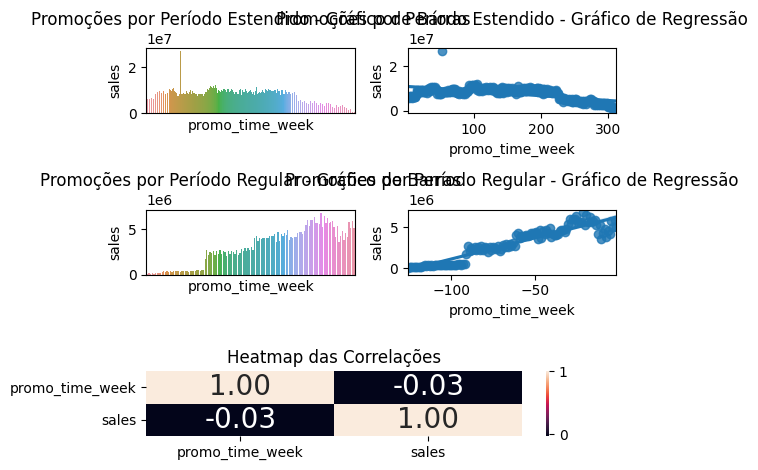

In [99]:
# Agrupar e somar vendas por semana de promoção
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(3, 2)

# Primeiro subplot: Gráfico de barras para promoções por período estendido
plt.subplot( grid[0, 0] )
aux2 =  aux1[aux1['promo_time_week'] > 0] # promoção por periodo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks([]) # Remover rótulos do eixo x
plt.title('Promoções por Período Estendido - Gráfico de Barras')

# Segundo subplot: Gráfico de regressão para promoções por período estendido
plt.subplot( grid[0, 1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Promoções por Período Estendido - Gráfico de Regressão')

# Terceiro subplot: Gráfico de barras para promoções por período regular
plt.subplot( grid[1, 0] )
aux3 =  aux1[aux1['promo_time_week'] < 0] # promoção por periodo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks([]) # Remover rótulos do eixo x
plt.title('Promoções por Período Regular - Gráfico de Barras')

# Quarto subplot: Gráfico de regressão para promoções por período regular
plt.subplot( grid[1,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Promoções por Período Regular - Gráfico de Regressão')

# Quinto subplot: Heatmap das correlações
plt.subplot(grid[2,:])
sns.heatmap(aux1.corr(method='pearson'), annot=True, fmt='.2f', annot_kws={"size": 20})
plt.title('Heatmap das Correlações')

plt.tight_layout();

### <s>`H5`.Lojas com mais dias de promoção deveriam vender mais.</s>

- A Hipótese 5, será analisada no próximo ciclo.

### `H6`.Lojas com promoções consecutivas deveriam vender mais.

##### **`FALSA`** Lojas com promoção consecutivas vendem menos

- Observamos que as lojas com promoções consecutivas vendem menos. Esse pode ser um insight importante para o negócio.

- Relevância para o modelo: baixa. Analisando essas variáveis isoladamente, elas não parecem ser muito relevantes para o modelo, pois há apenas uma pequena diferença no gráfico. Posteriormente, obteremos uma segunda opinião de um algoritmo.

In [100]:
info['promo'], info['promo2']

('promo Indica se uma loja está executando uma promoção naquele dia: 0 = a loja não está participando, 1 = a loja está participando.',
 'Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando')

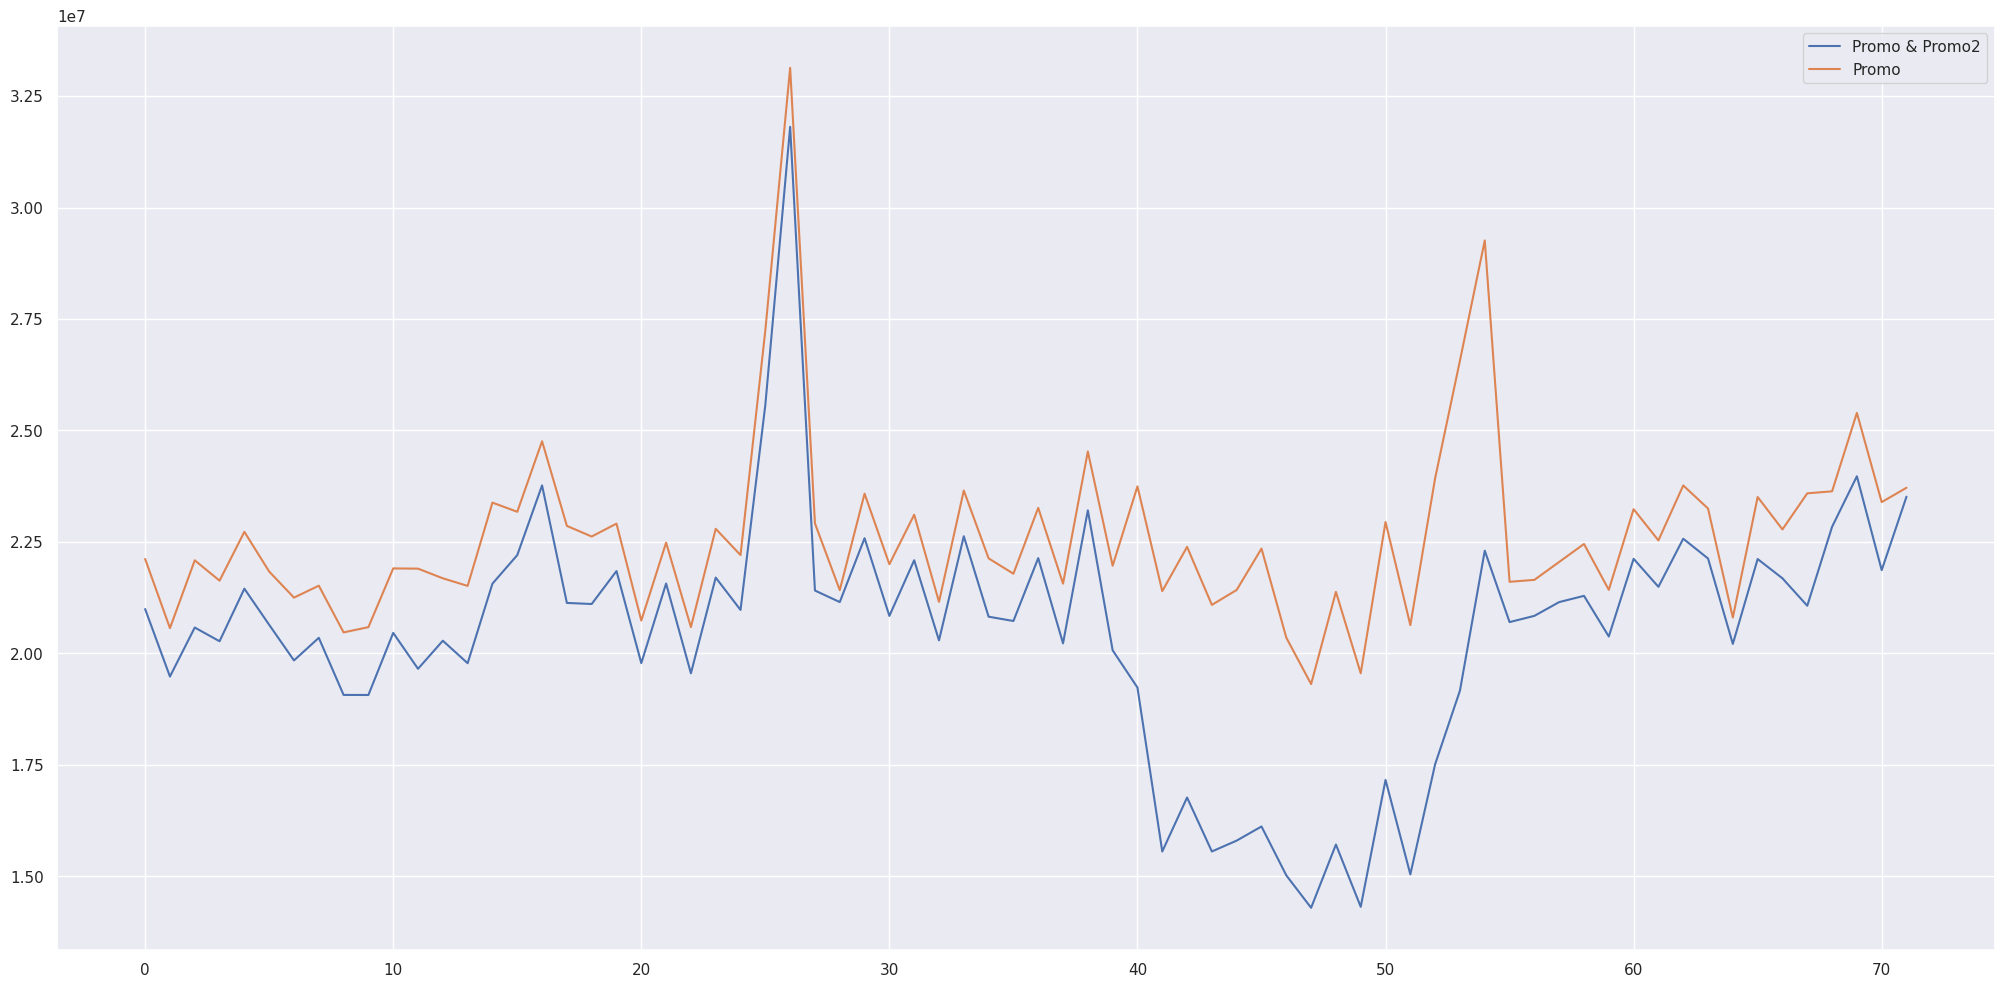

In [106]:
# Filtrar as lojas que estão participando do período promocional tradicional e extendido 
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# Filtrar as lojas que apenas participaram do período promocional tradicional 
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Promo & Promo2', 'Promo']);